In [2]:
import numpy as np
import pandas as pd
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt

In [3]:
initial_projects = pd.read_csv("InnitialData.csv")

initial_projects

,Project,Duration,Expected revenue,Standart deviation
0,Data analytics tools 1,5,3.71,1.13155
1,Customizable reports,5,3.34,0.91850
2,Compatibility with other software,5,3.17,0.86858
3,Data analytics tools 2,4,2.91,0.75078
4,Enhanced administrative tools,4,2.62,0.61046
5,Enhanced user interface,3,1.95,0.46020
6,Social media components,3,1.79,0.39022


In [4]:
def generate_d():
    return np.random.choice(np.array([5, 5, 4, 3]))

def generate_S_k_t(tilde_xi_k_t_i, time_horizon, number_of_scenarios):
    # Initialize S_k_t as a list of lists for each scenario and time step
    S_k_t = [[[] for _ in range(1, time_horizon + 1)] for _ in range(number_of_scenarios)]

    # Precompute hashes for tilde_xi arrays for efficient comparison
    hashes = [
        {t: hash(tuple(tilde_xi_k_t_i[k][t])) for t in range(1, time_horizon + 1)}
        for k in range(number_of_scenarios)
    ]

    # Compare scenarios to find matching time steps
    for idx in range(number_of_scenarios):
        for i in range(number_of_scenarios):
            if idx != i:  # Avoid comparing a scenario with itself
                for t in range(1, time_horizon + 1):
                    if hashes[idx][t] == hashes[i][t]:
                        S_k_t[idx][t].append(i)
                    else:
                        break  # Stop comparing at the first mismatch
    return S_k_t


def generate_projects_scenario(initial_projects, m, lambd, alpha, time_horizon):

    d = list(initial_projects['Duration'].values)
    s = [0] * len(d)
    f = d.copy()
    eps = [np.round(np.random.normal(i, j),3) for i, j in zip(initial_projects['Expected revenue'], initial_projects['Standart deviation'])]

    for t in range(1, time_horizon+1):
        for i in range(0, m):
            d_rand = generate_d()
            d.append(d_rand)
            eps.append(np.round(np.random.normal(d_rand*lambd, d_rand*alpha), 3))
            s.append(t)
            f.append(t+d_rand)

    tilde_xi_t_i = np.zeros((time_horizon+1, len(d)))

    for i in range(len(d)):
        if f[i]<=time_horizon:
            tilde_xi_t_i[f[i], i] = eps[i]
    
    C = [[] for i in range(0, time_horizon + 1)]

    for j, i in enumerate(f):
        if i<=time_horizon:
            C[i].append(j)

    I = [[] for i in range(0, time_horizon + 1)]

    for i in range(0, time_horizon + 1):
        for j, (start, finish) in enumerate(zip(s,f)):
            if start<=i<=finish:
                I[i].append(j)

    T = []
    
    for start, finish in zip(s,f):
        T.append([t for t in range(start, finish+1)])
    
    return C, I, T, tilde_xi_t_i, s

def generate_K_scenario(n,m, initial_projects, lambd, alpha, time_horizon):
    C_k_t = []
    I_k_t = []
    T_k_i = []
    tilde_xi_k_t_i = []
    s_k_i = []

    for i in range(n):
        
        C, I, T, tilde_xi_t_i, s = generate_projects_scenario(initial_projects, m, lambd, alpha, time_horizon)
        C_k_t.append(C)
        I_k_t.append(I)
        T_k_i.append(T)
        tilde_xi_k_t_i.append(tilde_xi_t_i)
        s_k_i.append(s)
    
    S_k_t = generate_S_k_t(tilde_xi_k_t_i, time_horizon, n)


    return C_k_t, I_k_t, T_k_i, tilde_xi_k_t_i, s_k_i, S_k_t

In [5]:
def check_feasibility(R, r, q, p, F, U):

    model = Model("FA_r")
    model.setParam('OutputFlag', 0)

    y = {}
    beta = {}

    for k in range(number_of_scenarios): 
        for t in range(1, r+1):
            for i in I_k_t[k][t]: 
                if t in T_k_i[k][i]:
                    y[k, t, i] = model.addVar(vtype=GRB.BINARY, name=f"y_{k}_{t}_{i}")

    for k in range(number_of_scenarios):
        for t in range(1, r):
            for i in I_k_t[k][t]: 
                if t+1 in T_k_i[k][i]:
                    model.addConstr(y[k, t, i] >= y[k, t + 1, i], 
                                    name=f"TemporalConsistency_k{k}_t{t}_i{i}")

    for k in range(number_of_scenarios):
        for t in range(1, r + 1):  # Adjust this range to `s_i` to `r` if needed
            for i in I_k_t[k][t]:  # Iterate over `i` in the index set  
                if t >= s_k_i[k][i]:
                    for k_prime in S_k_t[k][t]:  
                            model.addConstr(y[k, t, i] == y[k_prime, t, i], 
                                            name=f"NonAnticipativity_k{k}_kprime{k_prime}_t{t}_i{i}")
                        
    for k in range(number_of_scenarios): 
        for t in range(1, r + 1): 
                model.addConstr(quicksum(y[k, t, i] for i in I_k_t[k][t]) <= U, name=f"CapacityConstraint_k{k}_t{t}")

    for k in range(number_of_scenarios):
        beta[k] = model.addVar(vtype=GRB.BINARY, name=f"beta_{k}")

    model.addConstr(
        quicksum(q * beta[k] for k in range(number_of_scenarios)) >= p,
        name="ProbabilityThreshold"
    )

    for k in range(number_of_scenarios):  # Loop over scenarios
        lhs = quicksum(
            y[k, t, i] * tilde_xi_k_t_i[k][t][i]  # Accumulated return
            for t in range(3, r + 1)
            for i in C_k_t[k][t]
        ) - r * F  # Subtract fixed cost

        rhs = (
            R * beta[k] + (1 - beta[k]) *(-1)  # Penalty
        )

        model.addConstr(lhs >= rhs, name=f"ReturnLevel_k{k}")

    # Set dummy objective
    model.setObjective(0, GRB.MINIMIZE)

    # Solve the model
    model.optimize()

    if not model.Status == GRB.INFEASIBLE:
        return True
    else:
        return False


In [6]:
def expected_value_problem(tau, q, F, U):

    model = Model("EAM")
    model.setParam('OutputFlag', 0)

    y = {}

    for k in range(number_of_scenarios): 
        for t in range(1, tau+1):
            for i in I_k_t[k][t]: 
                if t in T_k_i[k][i]:
                    y[k, t, i] = model.addVar(vtype=GRB.BINARY, name=f"y_{k}_{t}_{i}")

    for k in range(number_of_scenarios):
        for t in range(1, tau):
            for i in I_k_t[k][t]: 
                if t+1 in T_k_i[k][i]:
                    model.addConstr(y[k, t, i] >= y[k, t + 1, i], 
                                    name=f"TemporalConsistency_k{k}_t{t}_i{i}")

    for k in range(number_of_scenarios):
        for t in range(1, tau + 1):  # Adjust this range to `s_i` to `r` if needed
            for i in I_k_t[k][t]:  # Iterate over `i` in the index set  
                if t >= s_k_i[k][i]: 
                    for k_prime in S_k_t[k][t]: 
                            model.addConstr(y[k, t, i] == y[k_prime, t, i], 
                                            name=f"NonAnticipativity_k{k}_kprime{k_prime}_t{t}_i{i}")
                        
    for k in range(number_of_scenarios): 
        for t in range(1, tau + 1): 
                model.addConstr(quicksum(y[k, t, i] for i in I_k_t[k][t]) <= U, name=f"CapacityConstraint_k{k}_t{t}")
    
    objective = quicksum(
        q * y[k, tau, i] * tilde_xi_k_t_i[k][tau][i]  # Weighted reward
        for k in range(number_of_scenarios)  # Over all scenarios
        for i in C_k_t[k][tau]  # Over all projects completing at tau_star
    ) - tau * F  # Subtract fixed cost

    # Set the objective in the model
    model.setObjective(objective, GRB.MAXIMIZE)

    # Solve the model
    model.optimize()

    if model.Status == GRB.OPTIMAL:
        print("Innitial upper-bound", model.objVal)
        return model.objVal
    else:
        print("The model did not converge to an optimal solution.")
        return None

In [7]:
def check_F_W_tau(tau, R_v, q, F, U, p, solution = False):
    
    model = Model("EAM")
    model.setParam('OutputFlag', 0)

    y = {}
    beta = {}

    for k in range(number_of_scenarios): 
        for t in range(1, tau+1):
            for i in I_k_t[k][t]: 
                if t in T_k_i[k][i]:
                    y[k, t, i] = model.addVar(vtype=GRB.BINARY, name=f"y_{k}_{t}_{i}")

    for k in range(number_of_scenarios):
        for t in range(1, tau):
            for i in I_k_t[k][t]: 
                if t+1 in T_k_i[k][i]:
                    model.addConstr(y[k, t, i] >= y[k, t + 1, i], 
                                name=f"TemporalConsistency_k{k}_t{t}_i{i}")

    for k in range(number_of_scenarios):
        for t in range(1, tau + 1):  # Adjust this range to `s_i` to `r` if needed
            for i in I_k_t[k][t]:  # Iterate over `i` in the index set  
                if t >= s_k_i[k][i]: 
                    for k_prime in S_k_t[k][t]: 
                        if t >= s_k_i[k][i]: 
                            model.addConstr(y[k, t, i] == y[k_prime, t, i], name=f"NonAnticipativity_k{k}_kprime{k_prime}_t{t}_i{i}")
                            
    for k in range(number_of_scenarios): 
        for t in range(1, tau + 1): 
                model.addConstr(quicksum(y[k, t, i] for i in I_k_t[k][t]) <= U, name=f"CapacityConstraint_k{k}_t{t}")
    
    for k in range(number_of_scenarios):
        beta[k] = model.addVar(vtype=GRB.BINARY, name=f"beta_{k}")

    model.addConstr(
        quicksum(q * beta[k] for k in range(number_of_scenarios)) >= p,
        name="ProbabilityThreshold"
    )

    for k in range(number_of_scenarios):  # Loop over scenarios
        # Compute LHS: Accumulated return minus fixed cost
        lhs = quicksum(
            y[k, tau, i] * tilde_xi_k_t_i[k][tau][i] for i in C_k_t[k][tau]
        ) - tau * F
        # Compute RHS: Return level or penalty term
        rhs = (
            R_v * beta[k]  # Return level achieved
            + (1 - beta[k]) * (-1 * tau)  # Penalty
        )

        # Add the constraint
        model.addConstr(lhs >= rhs, name=f"ReturnLevelConstraint_k{k}")

    
    # Set dummy objective
    model.setObjective(0, GRB.MINIMIZE)

    # Solve the model
    model.optimize()
    if not model.Status == GRB.INFEASIBLE:

        if solution:
            solution_beta = {}
            solution_y = {}
            for k in range(number_of_scenarios):
                solution_beta[k] = beta[k].x
                solution_y[k] = {}
                for t in range(1, tau + 1):
                    for i in I_k_t[k][t]:
                        solution_y[k][t, i] = y[k, t, i].x
            return solution_y, solution_beta
        
        return True
    else:
        return False

    

In [8]:
def get_first_upper(l_v):
    for tau in range(3, time_horizon+1):
        feasible = check_feasibility(l_v, tau, q, p, F, U)
        if feasible:
            print(f"For t={tau} is feasible.")
            u_v = expected_value_problem(tau, q, F, U)
            return u_v, tau

In [9]:
def bisection_method(l_v, eps):

    u_v, tau = get_first_upper(l_v)

    if u_v<l_v:
        print("Something went wrong")
        return
    
    counter = 1

    print(f"---------------------")

    while (u_v - l_v >= eps):

        print(f"Iteration: {counter}")
        print(f"Lower bound: {l_v}")
        print(f"Upper bound: {u_v}")
        print(f"---------------------")

        R_v = (l_v + u_v)/2

        if check_F_W_tau(tau, R_v, q, F, U, p):
            l_v = R_v
        else:
            u_v = R_v

        
        counter+=1

    return tau, l_v


In [10]:
target_R = 8
U = 100
eps = 0.001

time_horizon  = 10
lambd = 0.65
alpha = 0.4
number_of_scenarios = 200
number_of_projects_per_period = 4

q = 1/number_of_scenarios
p = 0.9
F = 0.1

C_k_t, I_k_t, T_k_i, tilde_xi_k_t_i, s_k_i, S_k_t = generate_K_scenario(number_of_scenarios, number_of_projects_per_period, initial_projects, lambd, alpha, time_horizon)

In [12]:
C_k_t[0]

[[],
 [],
 [],
 [5, 6],
 [3, 4, 8],
 [0, 1, 2, 7, 9, 12, 13, 14],
 [10],
 [11, 16, 17],
 [15, 18, 21, 24, 25, 26],
 [19, 20, 22, 29],
 [23, 31, 32]]

In [ ]:
I_k_t[0]

[[0, 1, 2, 3, 4, 5, 6],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
 [0,
  1,
  2,
  7,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26],
 [10, 11, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
 [11,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34],
 [15,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38],
 [19,
  20,
  22,
  23,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42],
 [23,
  27,
  28,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46]]

In [14]:
T_k_i[0]

[[0, 1, 2, 3, 4, 5],
 [0, 1, 2, 3, 4, 5],
 [0, 1, 2, 3, 4, 5],
 [0, 1, 2, 3, 4],
 [0, 1, 2, 3, 4],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [1, 2, 3, 4, 5],
 [1, 2, 3, 4],
 [1, 2, 3, 4, 5],
 [1, 2, 3, 4, 5, 6],
 [2, 3, 4, 5, 6, 7],
 [2, 3, 4, 5],
 [2, 3, 4, 5],
 [2, 3, 4, 5],
 [3, 4, 5, 6, 7, 8],
 [3, 4, 5, 6, 7],
 [3, 4, 5, 6, 7],
 [3, 4, 5, 6, 7, 8],
 [4, 5, 6, 7, 8, 9],
 [4, 5, 6, 7, 8, 9],
 [4, 5, 6, 7, 8],
 [4, 5, 6, 7, 8, 9],
 [5, 6, 7, 8, 9, 10],
 [5, 6, 7, 8],
 [5, 6, 7, 8],
 [5, 6, 7, 8],
 [6, 7, 8, 9, 10, 11],
 [6, 7, 8, 9, 10, 11],
 [6, 7, 8, 9],
 [6, 7, 8, 9, 10, 11],
 [7, 8, 9, 10],
 [7, 8, 9, 10],
 [7, 8, 9, 10, 11],
 [7, 8, 9, 10, 11],
 [8, 9, 10, 11, 12],
 [8, 9, 10, 11],
 [8, 9, 10, 11, 12, 13],
 [8, 9, 10, 11],
 [9, 10, 11, 12, 13, 14],
 [9, 10, 11, 12, 13, 14],
 [9, 10, 11, 12, 13],
 [9, 10, 11, 12],
 [10, 11, 12, 13, 14, 15],
 [10, 11, 12, 13],
 [10, 11, 12, 13, 14, 15],
 [10, 11, 12, 13, 14, 15]]

In [15]:
tilde_xi_k_t_i[0]

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
      

In [25]:
S_k_t[0][1:]

[[1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  

In [28]:
t_star, R_star = bisection_method(target_R, eps)
solution_y, solution_beta = check_F_W_tau(t_star, R_star, q, F, U, p, solution = True)

For t=5 is feasible.
Innitial upper-bound 14.288375000000002
---------------------
Iteration: 1
Lower bound: 8
Upper bound: 14.288375000000002
---------------------
Iteration: 2
Lower bound: 8
Upper bound: 11.144187500000001
---------------------
Iteration: 3
Lower bound: 8
Upper bound: 9.57209375
---------------------
Iteration: 4
Lower bound: 8.786046875
Upper bound: 9.57209375
---------------------
Iteration: 5
Lower bound: 9.1790703125
Upper bound: 9.57209375
---------------------
Iteration: 6
Lower bound: 9.1790703125
Upper bound: 9.375582031250001
---------------------
Iteration: 7
Lower bound: 9.1790703125
Upper bound: 9.277326171875
---------------------
Iteration: 8
Lower bound: 9.2281982421875
Upper bound: 9.277326171875
---------------------
Iteration: 9
Lower bound: 9.25276220703125
Upper bound: 9.277326171875
---------------------
Iteration: 10
Lower bound: 9.25276220703125
Upper bound: 9.265044189453125
---------------------
Iteration: 11
Lower bound: 9.258903198242187
Up

In [29]:
def return_project_portfolios(solution_y):
    T = []
    for idx in range(number_of_scenarios):

        t = [[] for i in range(0, t_star+1)]

        for j in solution_y[idx].keys():
            if solution_y[idx][j]!=0:
                t[j[0]].append(j[1])
        T.append(t[1: t_star+1])
    return T

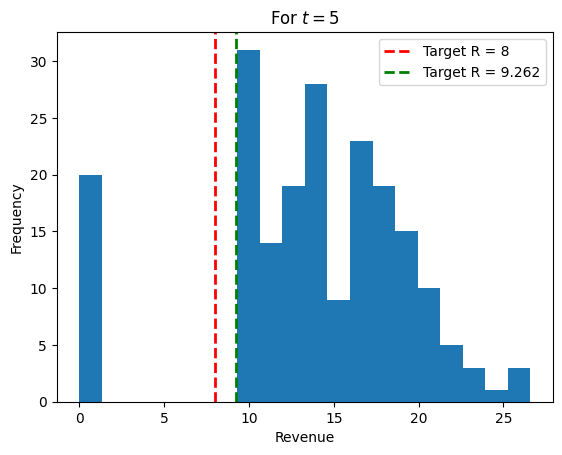

In [30]:
R = []

for idx in range(number_of_scenarios):

    t = [[] for i in range(0, t_star+1)]

    for j in solution_y[idx].keys():
        if solution_y[idx][j]!=0:
            t[j[0]].append(j[1])

    R.append(sum([sum(tilde_xi_k_t_i[idx][i][t[i]]) for i in range(3, t_star+1)])) 
    

plt.hist(R, bins=20)  # 20 columns (bins)
plt.xlabel('Revenue')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.title(f'For $t = {t_star}$')  # Title of the plot
plt.axvline(target_R, color='red', linestyle='--', linewidth=2, label=f'Target R = {target_R}') # X-axis label
plt.axvline(R_star, color='green', linestyle='--', linewidth=2, label=f'Target R = {np.round(R_star, 3)}') # X-axis label
plt.legend()
plt.show()


In [51]:
total_projects = len(s_k_i[0])
prob = np.zeros((t_star, total_projects))

In [52]:
T = return_project_portfolios(solution_y)

for i in T:
    for time, j in enumerate(i):
        for k in j:
            prob[time][k] += 1/number_of_scenarios

In [ ]:
for t in range(1, t_star+1):
    idx = np.arange(total_projects)[prob[t-1]>0]
    print(f"In period {t}")
    text=""
    counter = 0
    for i,j in zip(prob[t-1][idx], idx):
        text+=f"p({j}) = {np.round(i, 2)} "
        counter+=1
        if counter%8 == 0:
            text+="\n"
    print(text)
    print()

In period 1
p(0) = 1.0 p(1) = 1.0 p(2) = 1.0 p(3) = 1.0 p(4) = 1.0 p(5) = 1.0 p(6) = 1.0 p(7) = 1.0 
p(8) = 1.0 p(9) = 1.0 p(10) = 1.0 

In period 2
p(0) = 1.0 p(1) = 1.0 p(2) = 1.0 p(7) = 1.0 p(8) = 1.0 p(9) = 1.0 p(10) = 1.0 p(11) = 1.0 
p(12) = 1.0 p(13) = 1.0 p(14) = 1.0 

In period 3
p(0) = 1.0 p(1) = 1.0 p(2) = 1.0 p(7) = 0.19 p(8) = 0.28 p(9) = 0.24 p(10) = 0.21 p(11) = 0.26 
p(12) = 0.22 p(13) = 0.24 p(14) = 0.27 p(15) = 1.0 p(16) = 1.0 p(17) = 1.0 p(18) = 1.0 

In period 4
p(0) = 0.9 p(1) = 0.87 p(2) = 0.89 p(7) = 0.18 p(8) = 0.28 p(9) = 0.23 p(10) = 0.2 p(11) = 0.25 
p(12) = 0.21 p(13) = 0.23 p(14) = 0.26 

In period 5
p(0) = 0.89 p(1) = 0.87 p(2) = 0.87 p(7) = 0.18 p(8) = 0.28 p(9) = 0.23 p(10) = 0.2 p(11) = 0.23 
p(12) = 0.21 p(13) = 0.23 p(14) = 0.25 



In [27]:
T

NameError: name 'T' is not defined